# Solutions

## About the data
These exercises use the [`stock_analysis` package](https://github.com/stefmolin/stock-analysis) for collection of financial data.

## Setup

In [1]:
%matplotlib inline
import stock_analysis
from stock_analysis.utils import group_stocks, describe_group

reader = stock_analysis.StockReader('2017-01-01', '2018-12-31')

# get bitcoin data
bitcoin = reader.get_bitcoin_data()

# get faang data
fb, aapl, amzn, nflx, goog = (
    reader.get_ticker_data(ticker) \
    for ticker in ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
)

# get S&P 500 data
sp = reader.get_index_data()

faang = group_stocks(
    {
        'Facebook' : fb, 
        'Apple' : aapl, 
        'Amazon' : amzn, 
        'Netflix' : nflx, 
        'Google' : goog
    }
)

faang_sp = group_stocks(
    {
        'Facebook' : fb, 
        'Apple' : aapl, 
        'Amazon' : amzn, 
        'Netflix' : nflx, 
        'Google' : goog,
        'S&P 500' : sp
    }
)

bit_sp = group_stocks(
    {
        'Bitcoin' : bitcoin,
        'S&P 500' : sp
    }
)

all_assets = group_stocks(
    {
        'Bitcoin' : bitcoin,
        'S&P 500' : sp,
        'Facebook' : fb, 
        'Apple' : aapl, 
        'Amazon' : amzn, 
        'Netflix' : nflx, 
        'Google' : goog
    }
)

## Exercise 1
Using the `StockAnalyzer` and `StockVisualizer`, calculate and plot three levels of support and resistance for Netflix on the closing price from 2017-2018.

Text(0, 0.5, 'price ($)')

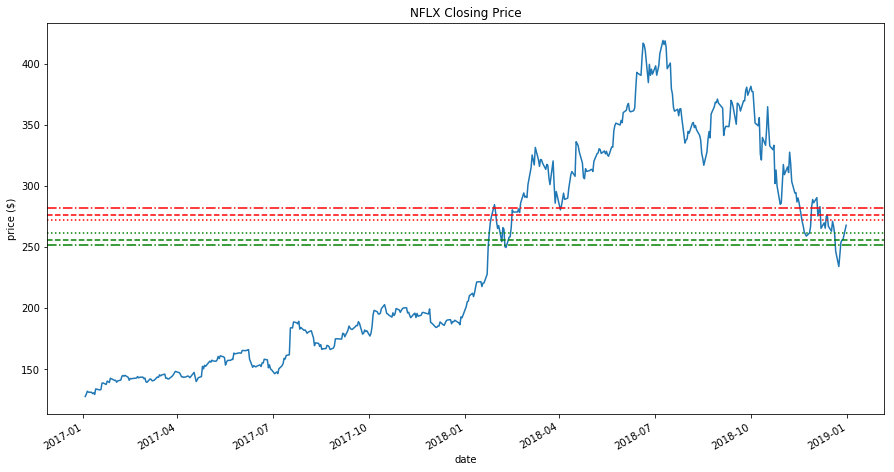

In [2]:
import itertools

def levels(analyzer, method):
    return [getattr(analyzer, method)(i) for i in range(1, 4)]

# calculate support/resistance levels
nflx_analyzer = stock_analysis.StockAnalyzer(nflx)
support_levels, resistance_levels = (
    levels(nflx_analyzer, metric) for metric in ['support', 'resistance']
)

nflx_viz = stock_analysis.StockVisualizer(nflx)
ax = nflx_viz.evolution_over_time('close', figsize=(15, 8), title='NFLX Closing Price')

for support, resistance, linestyle, level in zip(
    support_levels, resistance_levels, 
    [':', '--', '-.'], itertools.count(1)
):
    nflx_viz.add_reference_line(
        ax, 
        y=support, 
        label=f'support level {level}', 
        color='green', 
        linestyle=linestyle
    )
    nflx_viz.add_reference_line(
        ax, 
        y=resistance, 
        label=f'resistance level {level}', 
        color='red', 
        linestyle=linestyle
    )
ax.get_legend().remove()
ax.set_ylabel('price ($)')

## Exercise 2
With the `StockVisualizer`, look at the effect of after hours trading on the FAANG stocks.
1. As individual stocks
2. As the group using the sum of their closing and opening prices

### Part 1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1CC1E270>,
      dtype=object)

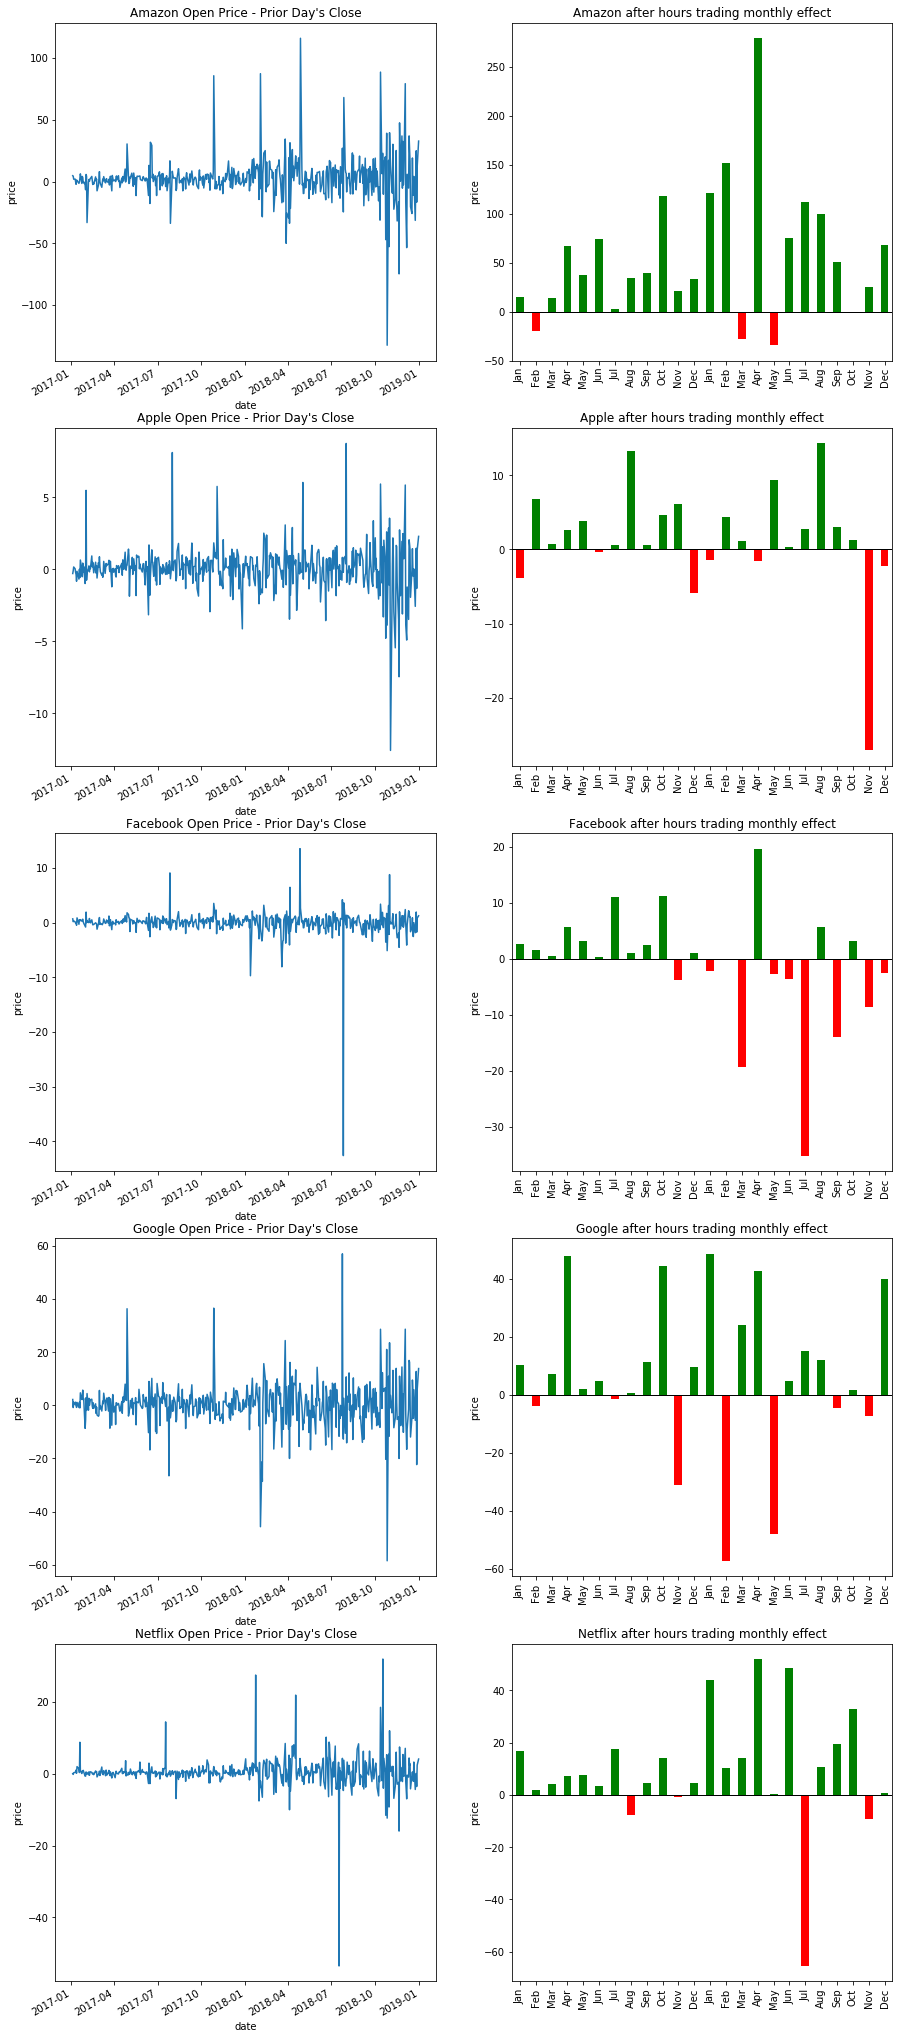

In [3]:
stock_analysis.AssetGroupVisualizer(faang).after_hours_trades()

### Part 2

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1EDD0E30>,
      dtype=object)

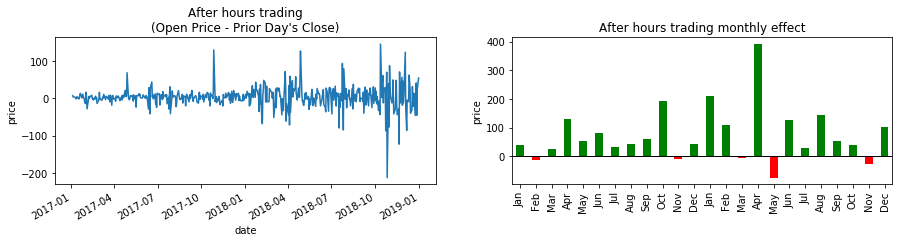

In [4]:
from stock_analysis.utils import make_portfolio
stock_analysis.StockVisualizer(
    make_portfolio(faang)
).after_hours_trades()

## Exercise 3
### FAANG Portfolio
Using the `StockVisualizer.open_to_close()` method, create a plot that fills the area between the FAANG portfolio's opening price and its closing price each day in red if the price declined and in green if the price increased.

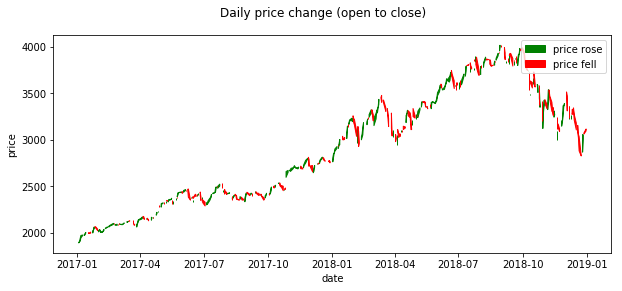

In [5]:
from stock_analysis.utils import make_portfolio
stock_analysis.StockVisualizer(make_portfolio(faang)).open_to_close()

### Bonus: Portfolio of S&P 500 and Bitcoin

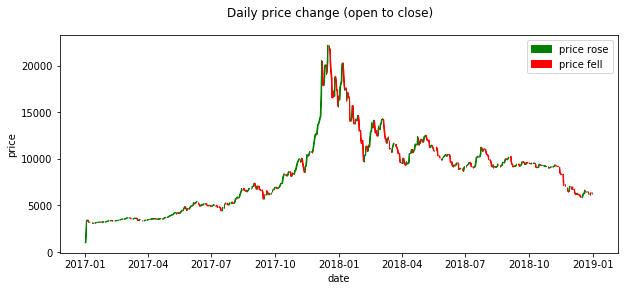

In [6]:
import pandas as pd
import numpy as np

sp_reindexed = sp.reindex(
    pd.date_range('2017-01-01', end='2018-12-31', freq='D')
).assign(
    volume=lambda x: x.fillna(0),
    close=lambda x: x.fillna(method='ffill'),
    open=lambda x: np.where(x.open.isnull(), x.close, x.open),
    high=lambda x: np.where(x.high.isnull(), x.close, x.high),
    low=lambda x: np.where(x.low.isnull(), x.close, x.low)
)

sp_reindexed.index.rename('date', inplace=True)

stock_analysis.StockVisualizer(
    make_portfolio(group_stocks({'bitcoin': bitcoin, 'sp500': sp_reindexed}))
).open_to_close()

## Exercise 4
Compare a mutual fund or ETF (Exchange Traded Fund) of your choice to 3 of its largest assets (by composition), using annualized volatility and the `AssetGroupAnalyzer`. These funds are built to mitigate risk, so volatility for the fund will be lower than that of the assets that compose it.

*Note: Solution uses the mutual fund FBALX, whose composition can be found at https://fundresearch.fidelity.com/mutual-funds/composition/316345206. Composition used for the solution taken on April 14, 2019.*

In [7]:
fbalx = reader.get_ticker_data('FBALX')
msft = reader.get_ticker_data('MSFT')
mutual_fund = group_stocks({
    '0 - FBALX' : fbalx,
    '1 - Microsoft' : msft,
    '2 - Apple' : aapl,
    '3 - Amazon' : amzn
})
stock_analysis.AssetGroupAnalyzer(mutual_fund).analyze(
    'annualized_volatility'
)

{'0 - FBALX': 0.13084907578280824,
 '1 - Microsoft': 0.2820922191050437,
 '2 - Apple': 0.28704998389950653,
 '3 - Amazon': 0.3606494699321407}

## Exercise 5
Write a function that returns a dataframe of one row with columns alpha, beta, annualized_volatility, is_bear_market, and is_bull_market which each contain the results of running the respective methods on a given stock using the `StockAnalyzer`. 

In [8]:
import pandas as pd

def metric_table(stock, index):
    """
    Make a table of metrics for a stock.

    Parameters:
        - stock: The stock's dataframe.
        - index: The dataframe for the index.
     
    Returns:
        A pandas DataFrame with a single row of metrics
    """
    return pd.DataFrame({
        metric : getattr(
            stock_analysis.StockAnalyzer(stock), 
            metric
        )(**kwargs) \
        for metric, kwargs in {
            'alpha' : {'index' : index, 'r_f' : 2.46}, 
            'beta' : {'index' : index}, 
            'annualized_volatility' : {},
            'is_bear_market' : {},
            'is_bull_market' : {}
        }.items()
    }, index=range(1))

metric_table(fbalx, sp)

,alpha,beta,annualized_volatility,is_bear_market,is_bull_market
0,-0.147329,0.632124,0.130849,False,False
